In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
stock_symbol = 'amzn'   
data = yf.download(stock_symbol, start='2010-01-01', end='2023-12-31')

# Display the first few rows of the data
print(data.head())

[*********************100%***********************]  1 of 1 completed

Price        Close    High     Low    Open     Volume
Ticker        AMZN    AMZN    AMZN    AMZN       AMZN
Date                                                 
2010-01-04  6.6950  6.8305  6.6570  6.8125  151998000
2010-01-05  6.7345  6.7740  6.5905  6.6715  177038000
2010-01-06  6.6125  6.7365  6.5825  6.7300  143576000
2010-01-07  6.5000  6.6160  6.4400  6.6005  220604000
2010-01-08  6.6760  6.6840  6.4515  6.5280  196610000


In [11]:
#use 'Close' price for prediction
data = data[['Close']]
data['Prediction'] = data['Close'].shift(-1)
data.dropna(inplace=True)

In [13]:
# Split the data into features (X) and target (y)
X = data['Close'].values   
y = data['Prediction'].values   
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

Mean Squared Error: 2.8514687659922373
R-squared: 0.9990588130846392


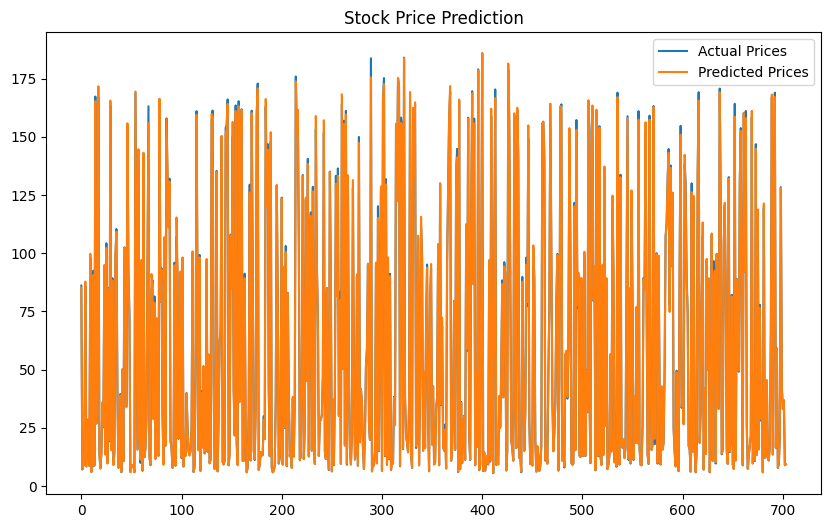

In [29]:
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")
r2 = r2_score(y_test, predictions)
print(f"R-squared: {r2}")
plt.figure(figsize=(10,6))
plt.plot(y_test, label='Actual Prices')
plt.plot(predictions, label='Predicted Prices')
plt.legend()
plt.title('Stock Price Prediction')
plt.show()

Random Forest Mean Squared Error: 5.047762721213024
R-squared: 0.9983338803210077


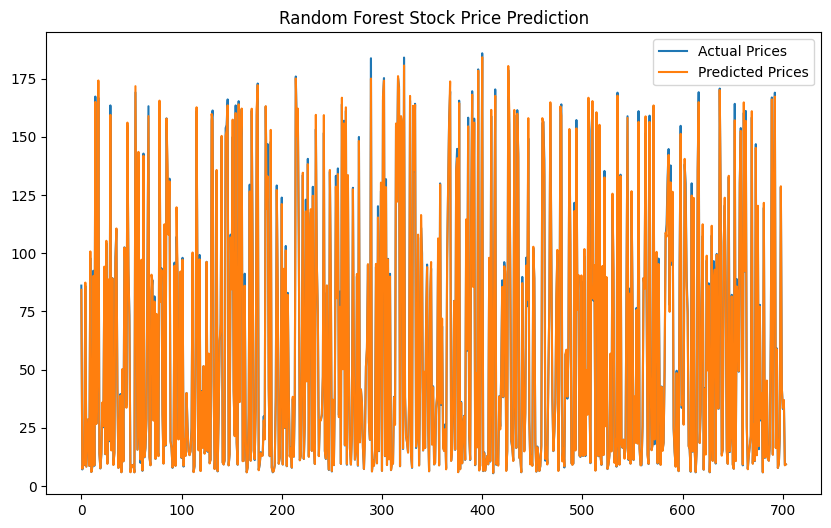

In [30]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_predictions)
print(f"Random Forest Mean Squared Error: {rf_mse}")
rfr2 = r2_score(y_test, rf_predictions)
print(f"R-squared: {rfr2}")
plt.figure(figsize=(10,6))
plt.plot(y_test, label='Actual Prices')
plt.plot(rf_predictions, label='Predicted Prices')
plt.legend()
plt.title('Random Forest Stock Price Prediction')
plt.show()


In [39]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message=".*__sklearn_tags__.*")

xgmodel = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# 5. Train the model
xgmodel.fit(X_train, y_train)

# 6. Make predictions on the test set
predictions = xgmodel.predict(X_test)

# 7. Evaluate the model's performance
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Print evaluation metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")

# 8. Optional: Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgmodel, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters from GridSearchCV
print(f"Best hyperparameters found: {grid_search.best_params_}")

# 9. Train the model with the best hyperparameters found from GridSearchCV
best_model = grid_search.best_estimator_

# 10. Make predictions with the best model
final_predictions = best_model.predict(X_test)

# 11. Evaluate the final model's performance
final_mse = mean_squared_error(y_test, final_predictions)
final_r2 = r2_score(y_test, final_predictions)

# Print final evaluation metrics
print(f"Final Mean Squared Error (MSE): {final_mse}")
print(f"Final R-squared (R²): {final_r2}")


Mean Squared Error (MSE): 3.3940320580610854
R-squared (R²): 0.9988797287203492


AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [17]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [18]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

In [19]:
X_lstm = []
y_lstm = []
for i in range(60, len(scaled_data)):
    X_lstm.append(scaled_data[i-60:i, 0])
    y_lstm.append(scaled_data[i, 0])

In [20]:
X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)
X_lstm = np.reshape(X_lstm, (X_lstm.shape[0], X_lstm.shape[1], 1))

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_lstm.shape[1], 1)),
    tf.keras.layers.LSTM(units=50, return_sequences=False),
    tf.keras.layers.Dense(units=1)
])

In [23]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_lstm, y_lstm, epochs=10, batch_size=32)
predictions_lstm = model.predict(X_lstm)
predictions_lstm = scaler.inverse_transform(predictions_lstm)


Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0211
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 6.2369e-04
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 5.5901e-04
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 5.0634e-04
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 4.5518e-04
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 5.0840e-04
Epoch 7/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 3.4311e-04
Epoch 8/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 3.9567e-04
Epoch 9/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 3.4461e-04
Epoch 10/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 3.1483e-04
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


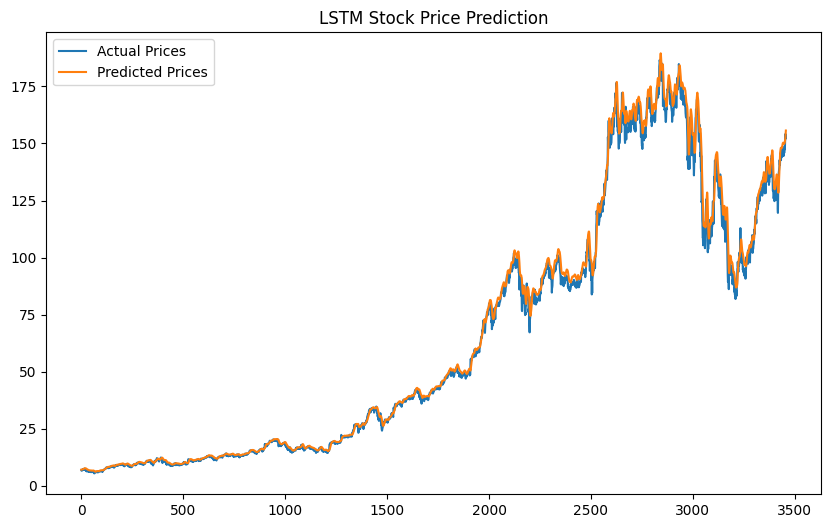

In [24]:
plt.figure(figsize=(10,6))
plt.plot(data['Close'].values[-len(predictions_lstm):], label='Actual Prices')
plt.plot(predictions_lstm, label='Predicted Prices')
plt.legend()
plt.title('LSTM Stock Price Prediction')
plt.show()

In [27]:
# Save the trained LSTM model
model.save('lstm_stock_price.h5')

# Save the scaler with pickle
import pickle
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)